In [1]:
import numpy as np
import scipy.special as special
import scipy.constants as cnst
import scipy.integrate as integrate
from Cluster import * 
from TolTEC import *
from matplotlib import pyplot as plt

In [2]:
theta1 = 10. #arcsec
mass1 = 10. ** 13. #mass cluster in solar masses
beta = .86
z1 = 1. 

c1 = Cluster(theta1, mass1, beta, z1)
r_c1 = c1.rc_kpc

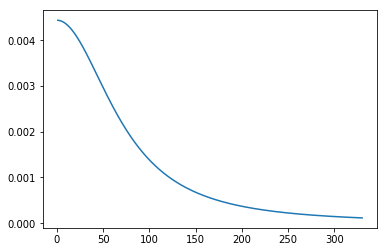

In [41]:
r_arr = np.arange(1., 4 * r_c1, .1)
profile = IB_model(r_arr, r_c1, beta, c1.n0_iccm)

plt.figure()
plt.plot(r_arr, profile)
#plt.plot(np.log10(r_arr), np.log10(profile))

In [35]:
mapSize = len(r_arr)

xx, yy = np.meshgrid(np.arange(-mapSize, mapSize), np.arange(-mapSize, mapSize))
mapMap = 0. * xx

r2 = r_arr ** 2
xy2 = xx ** 2 + yy ** 2

for ii in range(r_arr.size):
    mapMap[np.where(xy2 >= r2[ii])] = profile[ii]

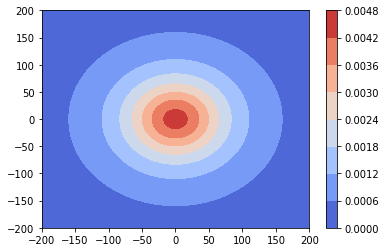

In [38]:
fig = plt.figure()
ax = fig.gca()
surf = plt.contourf(xx, yy, mapMap, cmap = 'coolwarm')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
fig.colorbar(surf)